In [1]:
#Notebook for experiments in gathering data

In [1]:
import os
import re
import csv
import requests
import warnings
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm, tqdm_notebook
#warnings.filterwarnings('ignore')

In [2]:
# load directors names
male_directors_path = f"../raw_data/director_lists/wiki/male_directors_wiki_latinized_20190616.csv"
female_directors_path = f"../raw_data/director_lists/wiki/female_directors_wiki_latinized_20190616.csv"
male_directors_df = pd.read_csv(male_directors_path)
female_directors_df = pd.read_csv(female_directors_path)
print(len(male_directors_df), len(female_directors_df))

1772 1035


In [3]:
male_names = set(male_directors_df.name)
female_names = set(female_directors_df.name)
print(len(male_names), len(female_names))

1772 1035


In [4]:
# ignore actresses/actors

male_directors_stop_list_path = "../raw_data/director_lists/wiki/so_called_male_directors_from_top_200_deadline_20190707.txt"
female_directors_stop_list_path = "../raw_data/director_lists/wiki/so_called_female_directors_from_top_170_deadline_20190707.txt"

with open(male_directors_stop_list_path, 'r') as f_male, open(female_directors_stop_list_path, 'r') as f_female:
    male_stop_names = set()
    for line in f_male:
        male_stop_names.add(line[:-1])
    male_names = male_names - male_stop_names    
    female_stop_names = set()    
    for line in f_female:
        female_stop_names.add(line[:-1])
    female_names = female_names - female_stop_names
        
print(len(male_names), len(female_names))

1746 991


In [27]:
#media_name = "deadline"
#media_name = "hollywood_reporter"
media_name = "variety"
path = f"../raw_data/full_{media_name}_df.csv"
df = pd.read_csv(path)
df = df.drop(df.columns[0], axis=1)
df.head()

,media,article_url,text_path,category,content_type,topics,title,author,published_at,tags
0,variety,https://variety.com/2016/film/columns/spotligh...,variety/153009.txt,columns,Article,"Awards, Columns, Features",'Spotlight': A Win for 'the Film Everyone Love...,Kristopher Tapley,2016-03-02 10:00:41,"Oscars 2016, Spotlight"
1,variety,https://variety.com/2017/film/columns/sofia-co...,variety/153010.txt,columns,Article,"Columns, Spotlight",Sofia Coppola: Do Audiences Still Want to Look...,Owen Gleiberman,2017-07-04 10:25:59,"Lost In Translation, Sofia Coppola, Somewhere,..."
2,variety,https://variety.com/2016/film/columns/reboots-...,variety/153011.txt,columns,Article,Columns,'Charlie's Angels' AGAIN? How Reboots of Reboo...,Owen Gleiberman,2016-08-07 14:40:03,"Charlies Angels, Ghostbusters, Spider Man"
3,variety,https://variety.com/2016/film/columns/oscars-2...,variety/153012.txt,columns,Article,"Columns, Features",Oscars: Ranking the Best Picture Nominees,"Justin Chang,Guy Lodge, Justin Chang, Guy Lodge",2016-02-25 16:01:05,"Mad Max: Fury Road, Oscars, Spotlight, The Big..."
4,variety,https://variety.com/2018/film/columns/oscars-2...,variety/153013.txt,columns,Article,"Awards, Columns, Features","'Beale Street,' 'First Man,' 'Mary Poppins' Sh...",Kristopher Tapley,2018-12-05 14:32:30,"First Man, If Beale Street Could Talk, Mary Po..."


In [29]:
def parse_date(str_date):
    year = (int)(str_date[:4])
    month = (int)(str_date[:7][5:])
    return (year, month)

def valid_date(str_date):
    year = parse_date(str_date)[0]
    if year >= 2008 and year <= 2018:
        return True
    else:
        return False;
    
def find_in(line, names):
    res = []
    for name in names:
        if name in line:
            res.append(name)
    return res    
    
def process(df, male_names, female_names):
    males = dict()
    females = dict()
    with tqdm(desc="rows", total=len(df)) as pbar_outer:    
        for row in df.itertuples():
            # check only required dates
            if media_name == 'deadline' or media_name == 'variety':
                str_date = getattr(row, 'published_at')
            elif media_name == 'hollywood_reporter':
                str_date = getattr(row, 'date')
            try:
                if not valid_date(str_date):
                    pbar_outer.update(1)
                    continue
            except:
                print(row)
                pbar_outer.update(1)
                continue
            
            # go through text to find directors
            month = parse_date(str_date)
            text_path = getattr(row, 'text_path')
            for line in open(f'../../modified_dfs/{text_path}'):
                # look up male names
                for name in find_in(line, male_names):
                    if month in males:
                        if name in males[month]:
                            males[month][name].append(text_path)                                 
                        else:
                            males[month][name] = [text_path]
                    else:
                        males[month] = {name : [text_path]}
                # look up female names        
                for name in find_in(line, female_names):
                    if month in females:
                        if name in females[month]:
                            females[month][name].append(text_path)                                                             
                        else:
                            females[month][name] = [text_path]
                    else:
                        females[month] = {name : [text_path]}    
            pbar_outer.update(1)
    return males, females            

males, females = process(df, male_names, female_names)            

rows:  47%|████▋     | 88565/187228 [14:01<18:07, 90.71it/s]  

Pandas(Index=88559, media='variety', article_url='https://variety.com/2013/film/news/thomas-mormon-upbringing-fuels-unique-coming-of-ager-1118063988/', text_path='variety/241568.txt', category='news', content_type='Article', topics='News, People News', title='Thomas: ', author=nan, published_at=nan, tags=nan)
Pandas(Index=88560, media=nan, article_url=nan, text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=88561, media='Anthony Kaufman', article_url='2013-01-07 04:00:00', text_path='Mormons, Pier Paolo Pasolini, Rasputin, Someone To Watch', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  47%|████▋     | 88654/187228 [14:02<22:34, 72.78it/s]

Pandas(Index=88635, media='variety', article_url='https://variety.com/2013/film/news/lowery-texan-talent-is-sundance-bound-1118063983/', text_path='variety/241642.txt', category='news', content_type='Article', topics='Features, Markets & Festivals, News, People News', title='Lowery: ', author=nan, published_at=nan, tags=nan)
Pandas(Index=88636, media='Gordon Cox', article_url='2013-01-07 04:00:00', text_path="Aint Them Bodies Saints, Assistant Directors, Burr Steers, David Lowery, David Miller, Directors To Watch, Frankfurt Kurnit Klein & Selz, Frankfurt Kurnit Klein & Setz, Peter Levinsohn, Prejudice and Zombies', Pride and Prejudice and Zombies, Pride Prejudice And Zombies, Pride Prejudice And Zombies Director, Screenwriters Lab, Sundance Film Festival", category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=88643, media='variety', article_url='https://variety.com/2013/film/news/krokidas-indie-darlings-to-provoke-discussion-in-sund

rows:  47%|████▋     | 88699/187228 [14:02<15:57, 102.89it/s]

Pandas(Index=88676, media='variety', article_url='https://variety.com/2013/film/news/lucas-moore-hangover-duo-take-their-brand-of-funny-behind-the-camera-1118063984/', text_path='variety/241681.txt', category='news', content_type='Article', topics='News, People News', title='Lucas & Moore: ', author=nan, published_at=nan, tags=nan)
Pandas(Index=88677, media='Carl Kozlowski', article_url='2013-01-07 04:00:00', text_path='Jon Lucas, Scott Moore', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  47%|████▋     | 88779/187228 [14:03<15:16, 107.47it/s]

Pandas(Index=88758, media='variety', article_url='https://variety.com/2013/film/news/lindholm-scribe-brings-reality-to-nail-biting-drama-1118063981/', text_path='variety/241762.txt', category='news', content_type='Article', topics='News, People News', title='Lindholm: ', author=nan, published_at=nan, tags=nan)
Pandas(Index=88759, media='Anthony Kaufman', article_url='2013-01-07 04:00:00', text_path='Nail Files, Tobias Lindholm', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  48%|████▊     | 89329/187228 [14:07<12:03, 135.32it/s]

Pandas(Index=89306, media='variety', article_url='https://variety.com/2012/film/news/lawrence-guterman-to-helm-short-sale-to-1118062913/', text_path='variety/242309.txt', category='news', content_type='Article', topics='News', title="Lawrence Guterman to helm 'Short Sale'", author=nan, published_at=nan, tags=nan)
Pandas(Index=89307, media='Dave McNary', article_url='2012-11-30 11:00:00', text_path='Intercept, Vilmos Zsigmond', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  48%|████▊     | 89510/187228 [14:09<18:35, 87.63it/s] 

Pandas(Index=89489, media='variety', article_url='https://variety.com/2012/film/news/insiders-upcoming-events-50-1118062059/', text_path='variety/242491.txt', category='news', content_type='Article', topics='News', title='Insiders: Upcoming ', author=nan, published_at=nan, tags=nan)
Pandas(Index=89490, media='Variety Staff', article_url='2012-11-12 04:00:00', text_path='Beverly Hilton, Bob Broder, Christina Davis, Human Rights Watch, Pearlena Igbokwe, Saban Free Clinic, Samie Kim Falvey, Upcoming Events', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  49%|████▉     | 91564/187228 [14:25<11:26, 139.42it/s]

Pandas(Index=91543, media='variety', article_url='https://variety.com/2012/film/news/focus-stays-downtown-as-docs-get-new-home-1118058713/', text_path='variety/244544.txt', category='news', content_type='Article', topics='Markets & Festivals, News', title='Focus stays downtown', author=nan, published_at=nan, tags=nan)
Pandas(Index=91544, media='Jennie Punter', article_url='2012-09-06 05:00:00', text_path='Bell Lightbox, Lightbox, Third Floor, Tiff Bell Lightbox, Toronto International Film Festival, Winter Garden Theater', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  49%|████▉     | 91647/187228 [14:26<13:13, 120.39it/s]

Pandas(Index=91632, media='variety', article_url='https://variety.com/2012/film/news/visual-effects-shops-draw-big-budget-pix-1118058358/', text_path='variety/244632.txt', category='news', content_type='Article', topics='Markets & Festivals, News', title='Visual effects shops draw ', author=nan, published_at=nan, tags=nan)
Pandas(Index=91633, media='Andrew Horn', article_url='2012-09-03 05:00:00', text_path='Berlin Film Festival 2012berlin Film Festival 2012, Big-budget Films, Budget, Charlie Woebcken, Draw It, London Visual Effects, Martin Scorcese, Matthias Schweighoefer, Ninja Assassin, Ninja Assassins, The Wachowskis, Underworld: Awakening, Visual Effects', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  49%|████▉     | 91704/187228 [14:27<11:58, 132.93it/s]

Pandas(Index=91682, media='variety', article_url='https://variety.com/2012/film/news/regional-studios-amp-vfx-facilities-1118058357/', text_path='variety/244681.txt', category='news', content_type='Article', topics='Markets & Festivals, News', title='Regional  studios', author=nan, published_at=nan, tags=nan)
Pandas(Index=91683, media='Ed Meza', article_url='2012-09-03 05:00:00', text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=91684, media='Ed Meza', article_url='2012-09-03 05:00:00', text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  49%|████▉     | 91799/187228 [14:27<11:43, 135.69it/s]

Pandas(Index=91770, media='variety', article_url='https://variety.com/2012/film/news/variety-reveals-10-actors-to-watch-1118058232/', text_path='variety/244767.txt', category='news', content_type='Article', topics='News', title='Variety reveals ', author=nan, published_at=nan, tags=nan)
Pandas(Index=91771, media='Variety Staff', article_url='2012-08-24 05:00:00', text_path='10 Actors to Watch, Actors, Bella Heathcote, Boyd Holbrook, Domhnall Gleeson, Hamptons Intl. Film Festival, Jennifer Stone, Producers To Watch', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  49%|████▉     | 92591/187228 [14:34<12:21, 127.70it/s]

Pandas(Index=92568, media='variety', article_url='https://variety.com/2012/film/news/yukfest-crowns-ha-ha-honorees-1118056935/', text_path='variety/245564.txt', category='news', content_type='Article', topics='News', title='Yukfest crowns ha-ha honorees ', author=nan, published_at=nan, tags=nan)
Pandas(Index=92569, media='Iain Blair', article_url='2012-07-24 15:00:00', text_path='Are You There Chelsea, Are You There Vodka It’s Me Chelsea, Are You There Vodka? Its Me Chelsea', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  51%|█████     | 95926/187228 [14:59<10:50, 140.26it/s]

Pandas(Index=95911, media='variety', article_url='https://variety.com/2012/film/news/tate-taylor-paul-selvin-award-honoree-1118050326/', text_path='variety/248906.txt', category='news', content_type='Article', topics='Awards, News', title='Tate Taylor: ', author=nan, published_at=nan, tags=nan)
Pandas(Index=95912, media='Shelby Hill', article_url='2012-02-17 04:00:00', text_path='Celia Taylor, Honoree, Jordan Kerner, Tate Taylor', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=95916, media='variety', article_url='https://variety.com/2012/film/news/hodge-career-catches-fire-with-bellflower-1118049916/', text_path='variety/248910.txt', category='news', content_type='Article', topics='News, People News', title='Hodge', author=nan, published_at=nan, tags=nan)
Pandas(Index=95917, media='John Anderson', article_url='2012-02-13 12:00:00', text_path='6 Souls, Bellflower, Camera Work, D.p.s, Emmanuel Lubezki, Enter The Void, Evan Glod

rows:  51%|█████▏    | 96282/187228 [15:01<11:22, 133.32it/s]

Pandas(Index=96268, media='variety', article_url='https://variety.com/2012/film/news/thesps-join-mcdonagh-on-calvary-1118049897/', text_path='variety/249261.txt', category='news', content_type='Article', topics='Markets & Festivals, News', title='Thesps join  ', author=nan, published_at=nan, tags=nan)
Pandas(Index=96269, media='Adam Dawtrey', article_url='2012-02-09 07:00:00', text_path='Berlin Film Festival, Irish Film And Television Academy, Irish Film And Tv Academy, Irish Film And Tv Awards, The Guard', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  52%|█████▏    | 96796/187228 [15:06<11:27, 131.46it/s]

Pandas(Index=96767, media='variety', article_url='https://variety.com/2012/film/news/tyro-focus-makes-fest-no-country-for-old-men-1118048628/', text_path='variety/249759.txt', category='news', content_type='Article', topics='Features, Markets & Festivals, News', title='Tyro focus makes fest ', author=nan, published_at=nan, tags=nan)
Pandas(Index=96768, media='Anthony Kaufman', article_url='2012-01-18 12:00:00', text_path='Sundance Film Festival', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  52%|█████▏    | 97081/187228 [15:09<27:43, 54.20it/s] 

Pandas(Index=97073, media='variety', article_url='https://variety.com/2012/film/news/fox-stirs-interest-in-bond-50th-anni-1118048440/', text_path='variety/250064.txt', category='news', content_type='Article', topics='Markets & Festivals, News', title='Fox stirs interest ', author=nan, published_at=nan, tags=nan)
Pandas(Index=97074, media='Marc Graser', article_url='2012-01-10 20:31:00', text_path='Consumer Electronics Show, For Your Eyes Only, Octopussy', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  52%|█████▏    | 97498/187228 [15:13<13:28, 111.03it/s]

Pandas(Index=97471, media='variety', article_url='https://variety.com/2011/film/news/alexander-payne-on-the-descendants-1118047304/', text_path='variety/250461.txt', category='news', content_type='Article', topics='News', title='Alexander Payne on ', author=nan, published_at=nan, tags=nan)
Pandas(Index=97472, media='Anthony Kaufman', article_url='2011-12-14 04:00:00', text_path='Academy Awards, Descendant, Descendants, Michelle Payne, Pitchfork, The Descendants', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=97493, media='variety', article_url='https://variety.com/2011/film/news/david-fincher-on-the-girl-with-the-dragon-tattoo-1118047300/', text_path='variety/250482.txt', category='news', content_type='Article', topics='News', title='David Fincher on ', author=nan, published_at=nan, tags=nan)
Pandas(Index=97494, media='Glenn Whipp', article_url='2011-12-14 04:00:00', text_path='Academy Awards, David A. Glenn, David Fincher, 

rows:  53%|█████▎    | 98590/187228 [15:22<09:06, 162.33it/s]

Pandas(Index=98567, media='variety', article_url='https://variety.com/2011/film/news/happy-feet-first-and-last-1118045922/', text_path='variety/251555.txt', category='news', content_type='Article', topics='News, VPage', title="'Happy Feet' ", author=nan, published_at=nan, tags=nan)
Pandas(Index=98568, media='Stephen Schaefer,Todd Kushigemachi, Stephen Schaefer, Todd Kushigemachi', article_url='2011-11-10 04:00:00', text_path='George Miller, Happy Feet, Happy Feet 2, Happy Feet Two, Mad Max: Fury Road, Skyrim', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  53%|█████▎    | 99071/187228 [15:25<10:25, 141.04it/s]

Pandas(Index=99055, media='variety', article_url='https://variety.com/2011/film/news/brazilians-going-nuts-for-dvds-1118044576/', text_path='variety/252042.txt', category='news', content_type='Article', topics='News', title='Brazilians going nuts ', author=nan, published_at=nan, tags=nan)
Pandas(Index=99056, media='Marc Graser', article_url='2011-10-17 05:00:00', text_path='Dvds, Nuts, The Adventures Of Tin Tin', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  53%|█████▎    | 99129/187228 [15:26<11:41, 125.64it/s]

Pandas(Index=99105, media='variety', article_url='https://variety.com/2011/film/news/three-set-for-independent-edge-thriller-1118044225/', text_path='variety/252091.txt', category='news', content_type='Article', topics='News', title='Three set', author=nan, published_at=nan, tags=nan)
Pandas(Index=99106, media='Dave McNary', article_url='2011-10-11 05:00:00', text_path='Alan Greenspan, Christopher Dodd, Donal Logue, Katie Cassidy, Michael Greenspan, Wrecked', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  53%|█████▎    | 99386/187228 [15:28<10:45, 136.16it/s]

Pandas(Index=99360, media='variety', article_url='https://variety.com/2011/film/news/goldsmith-back-as-variety-biz-editor-1118043753/', text_path='variety/252345.txt', category='news', content_type='Article', topics='News', title='Goldsmith back ', author=nan, published_at=nan, tags=nan)
Pandas(Index=99361, media='Variety Staff', article_url='2011-10-03 05:00:00', text_path='Jill Goldsmith', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=99394, media='variety', article_url='https://variety.com/2011/film/news/levy-s-job-is-a-dream-that-works-1118043795/', text_path='variety/252378.txt', category='news', content_type='Article', topics='News, People News', title="Levy's job ", author=nan, published_at=nan, tags=nan)
Pandas(Index=99395, media='Lisa Carroll', article_url='2011-10-04 05:00:00', text_path='Marvin Levy, Shoah Foundation', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  53%|█████▎    | 99510/187228 [15:29<12:16, 119.09it/s]

Pandas(Index=99503, media='variety', article_url='https://variety.com/2011/film/news/pubcasters-hunt-youth-with-period-miniseries-1118043423/', text_path='variety/252486.txt', category='news', content_type='Article', topics='Markets & Festivals, News', title='Pubcasters ', author=nan, published_at=nan, tags=nan)
Pandas(Index=99504, media=nan, article_url=nan, text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=99505, media='Emilio Mayorga', article_url='2011-10-01 05:00:00', text_path='Docurama, Tv3', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  53%|█████▎    | 99607/187228 [15:29<11:49, 123.48it/s]

Pandas(Index=99589, media='variety', article_url='https://variety.com/2011/film/news/variety-taps-grosz-as-awards-editor-1118043950/', text_path='variety/252570.txt', category='news', content_type='Article', topics='News, People News', title='Variety taps Grosz ', author=nan, published_at=nan, tags=nan)
Pandas(Index=99590, media='Variety Staff', article_url='2011-10-05 05:00:00', text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=99591, media='Variety Staff', article_url='2011-10-05 05:00:00', text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  53%|█████▎    | 99693/187228 [15:30<11:00, 132.43it/s]

Pandas(Index=99683, media='variety', article_url='https://variety.com/2011/film/news/no-fest-frenzy-but-deals-aplenty-1118042917/', text_path='variety/252662.txt', category='news', content_type='Article', topics='Markets & Festivals, News', title='No fest frenzy ', author=nan, published_at=nan, tags=nan)
Pandas(Index=99684, media='Diana Lodderhose,Dave McNary, Diana Lodderhose, Dave McNary', article_url='2011-09-16 05:00:00', text_path='Glen Basner and Steven Samuels, Scott Shooman, Things Fall Apart, Toronto International Film Festival, Trishna', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  53%|█████▎    | 99778/187228 [15:31<11:37, 125.30it/s]

Pandas(Index=99757, media='variety', article_url='https://variety.com/2011/film/news/dqe-seizes-opportunity-in-indian-animation-biz-1118043062/', text_path='variety/252735.txt', category='news', content_type='Article', topics='News', title='DQE seizes opportunity ', author=nan, published_at=nan, tags=nan)
Pandas(Index=99758, media=nan, article_url='2011-09-26 05:00:00', text_path='Dqe, Method Animation, Mipcom, Moonscoop, Toonz, Toonz Entertainment', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=99759, media=nan, article_url=nan, text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  54%|█████▎    | 100459/187228 [15:36<11:13, 128.88it/s]

Pandas(Index=100447, media='variety', article_url='https://variety.com/2011/film/news/greenlight-s-creative-lift-1118042080/', text_path='variety/253423.txt', category='news', content_type='Article', topics='News', title="Greenlight's ", author=nan, published_at=nan, tags=nan)
Pandas(Index=100448, media='Michelle Weiss', article_url='2011-09-01 05:00:00', text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=100449, media='Michelle Weiss', article_url='2011-09-01 05:00:00', text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  54%|█████▍    | 100746/187228 [15:38<10:31, 136.92it/s]

Pandas(Index=100731, media='variety', article_url='https://variety.com/2011/film/news/speakers-set-for-film-finance-confab-1118041130/', text_path='variety/253705.txt', category='news', content_type='Article', topics='News', title='Speakers set for ', author=nan, published_at=nan, tags=nan)
Pandas(Index=100732, media='Variety Staff', article_url='2011-08-10 05:00:00', text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=100733, media='Variety Staff', article_url='2011-08-10 05:00:00', text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  54%|█████▍    | 100974/187228 [15:40<09:38, 149.09it/s]

Pandas(Index=100946, media='variety', article_url='https://variety.com/2011/film/news/why-godfather-4-has-become-a-bore-1118041475/', text_path='variety/253918.txt', category='news', content_type='Article', topics='News', title="Why 'Godfather 4' ", author=nan, published_at=nan, tags=nan)
Pandas(Index=100947, media='Stephen Schaefer', article_url='2011-08-18 05:00:00', text_path='Andy Garcia', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  54%|█████▍    | 101054/187228 [15:40<10:03, 142.80it/s]

Pandas(Index=101020, media='variety', article_url='https://variety.com/2011/film/news/pacs-rack-up-bucks-for-prez-1118040752/', text_path='variety/253991.txt', category='news', content_type='Article', topics='News', title='PACs rack ', author=nan, published_at=nan, tags=nan)
Pandas(Index=101021, media='Ted Johnson', article_url='2011-08-02 05:00:00', text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=101022, media='Ted Johnson', article_url='2011-08-02 05:00:00', text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  54%|█████▍    | 101120/187228 [15:41<10:47, 132.97it/s]

Pandas(Index=101095, media='variety', article_url='https://variety.com/2011/film/news/ali-wong-spitfire-standup-embraces-dark-1118040427/', text_path='variety/254064.txt', category='news', content_type='Article', topics='News', title='Ali Wong: ', author=nan, published_at=nan, tags=nan)
Pandas(Index=101096, media='Justin Shady', article_url='2011-07-26 13:00:00', text_path='Carolines On Broadway, Justin Shady, Pete Holmes, Richard Wong', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  54%|█████▍    | 101216/187228 [15:42<11:26, 125.29it/s]

Pandas(Index=101200, media='variety', article_url='https://variety.com/2011/film/news/amy-schumer-reality-show-survivor-cuts-to-front-of-pack-1118040426/', text_path='variety/254168.txt', category='news', content_type='Article', topics='News', title='Amy Schumer:  ', author=nan, published_at=nan, tags=nan)
Pandas(Index=101201, media='Steve Heisler', article_url='2011-07-26 13:00:00', text_path='Amy Schumer, Cuts, Last Comic Standing, Levity Entertainment Group, Pete Holmes, Reality Show, Survivor, The Cobbler, Thomas Middleditch', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  61%|██████    | 114146/187228 [17:37<18:51, 64.61it/s] 

Pandas(Index=114131, media='variety', article_url='https://variety.com/2010/film/news/bob-spitz-on-julie-and-julia-1118013331/', text_path='variety/267098.txt', category='news', content_type='Article', topics='Awards, Markets & Festivals, News', title='Bob Spitz on', author=nan, published_at=nan, tags=nan)
Pandas(Index=114132, media='Variety Staff', article_url='2010-01-05 14:19:54', text_path='Academy Awards', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=114134, media='variety', article_url='https://variety.com/2010/film/news/anthony-swofford-on-the-messenger-1118013308/', text_path='variety/267100.txt', category='news', content_type='Article', topics='Awards, Markets & Festivals, News', title='Anthony Swofford on', author=nan, published_at=nan, tags=nan)
Pandas(Index=114135, media='Variety Staff', article_url='2010-01-05 12:00:00', text_path='Academy Awards, Amy Nicholson, Oren Moverman, The Messenger', category=nan, cont

rows:  61%|██████    | 114198/187228 [17:38<12:17, 99.04it/s]

Pandas(Index=114174, media='variety', article_url='https://variety.com/2010/film/news/paul-rudnick-on-fantastic-mr-fox-1118013334/', text_path='variety/267138.txt', category='news', content_type='Article', topics='Awards, Markets & Festivals, News', title="Paul Rudnick on '", author=nan, published_at=nan, tags=nan)
Pandas(Index=114175, media='Variety Staff', article_url='2010-01-05 14:32:49', text_path='Academy Awards', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=114192, media='variety', article_url='https://variety.com/2010/film/news/john-riggi-on-500-days-of-summer-1118013306/', text_path='variety/267155.txt', category='news', content_type='Article', topics='Awards, Markets & Festivals, News', title="John Riggi on '", author=nan, published_at=nan, tags=nan)
Pandas(Index=114193, media=nan, article_url=nan, text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(

rows:  61%|██████    | 114237/187228 [17:38<12:19, 98.67it/s] 

Pandas(Index=114220, media='variety', article_url='https://variety.com/2010/film/news/arianna-huffington-on-the-informant-1118013338/', text_path='variety/267181.txt', category='news', content_type='Article', topics='Awards, Markets & Festivals, News', title='Arianna Huffington on', author=nan, published_at=nan, tags=nan)
Pandas(Index=114221, media=nan, article_url=nan, text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=114222, media='Arianna Huffington', article_url='2010-01-05 14:43:25', text_path='Academy Awards', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows:  61%|██████    | 114260/187228 [17:38<12:33, 96.79it/s] 

Pandas(Index=114244, media='variety', article_url='https://variety.com/2010/film/news/ted-humphrey-on-district-9-1118013307/', text_path='variety/267203.txt', category='news', content_type='Article', topics='Awards, Markets & Festivals, News', title='Ted Humphrey on', author=nan, published_at=nan, tags=nan)
Pandas(Index=114245, media=nan, article_url=nan, text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=114246, media='Variety Staff', article_url='2010-01-05 12:00:00', text_path='Academy Awards', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=114260, media='variety', article_url='https://variety.com/2010/film/news/john-patrick-shanley-on-the-loss-of-a-teardrop-diamond-1118013332/', text_path='variety/267217.txt', category='news', content_type='Article', topics='Awards, Markets & Festivals, News', title='John Patrick Shanley on', author=nan, published_at=

rows:  61%|██████    | 114316/187228 [17:39<10:41, 113.67it/s]

Pandas(Index=114302, media='variety', article_url='https://variety.com/2010/film/news/john-oliver-on-in-the-loop-1118013333/', text_path='variety/267257.txt', category='news', content_type='Article', topics='Awards, Markets & Festivals, News', title="John Oliver on '", author=nan, published_at=nan, tags=nan)
Pandas(Index=114303, media=nan, article_url=nan, text_path=nan, category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=114304, media='Variety Staff', article_url='2010-01-05 14:29:17', text_path='Academy Awards', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)
Pandas(Index=114306, media='variety', article_url='https://variety.com/2010/film/news/donald-margulies-on-adventureland-1118013335/', text_path='variety/267259.txt', category='news', content_type='Article', topics='Awards, Markets & Festivals, News', title='Donald Margulies on', author=nan, published_at=nan, tags=nan)
Pandas(In

rows:  61%|██████    | 114371/187228 [17:39<10:47, 112.50it/s]

Pandas(Index=114373, media='variety', article_url='https://variety.com/2010/film/news/jeff-davis-on-the-hurt-locker-1118013337/', text_path='variety/267325.txt', category='news', content_type='Article', topics='Awards, Markets & Festivals, News', title="Jeff Davis on '", author=nan, published_at=nan, tags=nan)
Pandas(Index=114374, media='Variety Staff', article_url='2010-01-05 14:39:40', text_path='Academy Awards', category=nan, content_type=nan, topics=nan, title=nan, author=nan, published_at=nan, tags=nan)


rows: 100%|██████████| 187228/187228 [20:16<00:00, 153.88it/s]


In [30]:
female_path = f'./female_mention_backup_{media_name}_20190707.txt'
male_path = f'./male_mention_backup_{media_name}_20190707.txt'

In [31]:
with open(female_path, 'w') as f_out:
    for mnth, dct in females.items():    
        for name, articles in dct.items():
            res = str(mnth) + ' ' + name + ' '
            for item in articles:
                res += item + ' '
            res += '\n'   
            f_out.write(res)
            
with open(male_path, 'w') as f_out:
    for mnth, dct in males.items():    
        for name, articles in dct.items():
            res = str(mnth) + ' ' + name + ' '
            for item in articles:
                res += item + ' '
            res += '\n'   
            f_out.write(res)            

In [32]:
import string

alphabet_lower = string.ascii_lowercase + " -"
alphabet_full = string.ascii_uppercase + alphabet_lower

converter = {'á' : 'a',
             'ã' : 'a',
             'ä' : 'a',
             'ç' : 'c',
             'è' : 'e',
             'ě' : 'e',                         
             'é' : 'e',
             'ë' : 'e',
             'ę' : 'e',
             'í' : 'i',
             'ï' : 'i',
             'ñ' : 'n',
             'ó' : 'o',
             'ö' : 'o',
             'ø' : 'o',
             'ú' : 'u',
             'ü' : 'u',
             'ý' : 'y',
             'ć' : 'c',
             'ı' : 'i',
             'ł' : 'l',
             'ń' : 'n',
             'ň' : 'n',
             'ō' : 'o',
             'ô' : 'o',             
             'ś' : 's',
             'š' : 's',
             'ū' : 'u',
             'ž' : 'z',             
             'ż' : 'z',
             'É' : 'E',
             'Š' : 'S',             
             'Ž' : 'Z',
             'Ż' : 'Z'}

def contain_not_ascii(string):
    for ch in string:
        if ch not in alphabet_full:
            return True
    return False    

def convert_to_ascii(string):
    res = ""
    for ch in string:
        if ch not in alphabet_full:
            if ch in converter:
                ch = converter[ch]
            else:
                print(ch)
        res += ch
    return res    
    
convert_to_ascii("Pedro Almodóvar") 

'Pedro Almodovar'

In [33]:
## load from disk and process

def stats(path):
    dct = dict()    
    # construct dict from saved data
    for line in open(path, 'r'):    
        lst = line.split()                
        
        # parse date
        i = 0
        date = (lst[i][1:][:-1], lst[i+1][:-1])                        
        i = i + 2            
        
        # parse director`s name
        name = ''
        while lst[i][:len(media_name)] != media_name:
            if name != '':
                name += ' '
            name += lst[i]
            i = i + 1        

        # parse mentions
        mentions = set(lst[i:])
        mentions = len(mentions)
    
        # fill dict
        if date in dct:
            dct[date][name] = mentions
        else:
            dct[date] = {name : mentions}
    #####################################            
        
    # Calculate sorted dates (year, month) (x axis)
    dates = []
    for key, value in dct.items():
        dates.append(key)
    dates.sort()
    print("x(dates):", dates)
    print('\n')
    
    # Calculate mentions(x) -- number of articles per month
    mentions = []
    for x in dates:
        total_x = 0
        for key, value in dct[x].items():
            total_x += value
        mentions.append(total_x)
    print("y(mentions):", mentions)
    print('\n')
            
    # Calculate dict {name : fame}, where fame is number of mentions
    director_fame = dict()
    for x in dates:
        for name, value in dct[x].items():
            name = convert_to_ascii(name)
            if name in director_fame:
                director_fame[name] += value
            else:
                director_fame[name] = value

    # Calculate directors list sorted by fame
    fame = []            
    for name, score in director_fame.items():
        fame.append((score, name))
    fame = sorted(fame, key=lambda x: (-x[0], x[1]))
    for x in fame:
        print(x)
        
    return dates, mentions, fame

In [34]:
dates, mentions, fame = stats(female_path)

with open(f'female_mentions_per_month_{media_name}_20190707.txt', 'w') as f_out:
    for i in range(len(dates)):
        f_out.write(str(dates[i]) + ' ' + str(mentions[i]) + '\n')

with open(f'female_fame_top_{media_name}_20190707.txt', 'w') as f_out:       
    for p in fame:
        f_out.write(str(p) + '\n')

x(dates): [('2008', '1'), ('2008', '10'), ('2008', '11'), ('2008', '12'), ('2008', '2'), ('2008', '3'), ('2008', '4'), ('2008', '5'), ('2008', '6'), ('2008', '7'), ('2008', '8'), ('2008', '9'), ('2009', '1'), ('2009', '10'), ('2009', '11'), ('2009', '12'), ('2009', '2'), ('2009', '3'), ('2009', '4'), ('2009', '5'), ('2009', '6'), ('2009', '7'), ('2009', '8'), ('2009', '9'), ('2010', '1'), ('2010', '10'), ('2010', '11'), ('2010', '12'), ('2010', '2'), ('2010', '3'), ('2010', '4'), ('2010', '5'), ('2010', '6'), ('2010', '7'), ('2010', '8'), ('2010', '9'), ('2011', '1'), ('2011', '10'), ('2011', '11'), ('2011', '12'), ('2011', '2'), ('2011', '3'), ('2011', '4'), ('2011', '5'), ('2011', '6'), ('2011', '7'), ('2011', '8'), ('2011', '9'), ('2012', '1'), ('2012', '10'), ('2012', '11'), ('2012', '12'), ('2012', '2'), ('2012', '3'), ('2012', '4'), ('2012', '5'), ('2012', '6'), ('2012', '7'), ('2012', '8'), ('2012', '9'), ('2013', '1'), ('2013', '10'), ('2013', '11'), ('2013', '12'), ('2013', '2

In [35]:
dates, mentions, fame = stats(male_path)

with open(f'male_mentions_per_month_{media_name}_20190707.txt', 'w') as f_out:
    for i in range(len(dates)):
        f_out.write(str(dates[i]) + ' ' + str(mentions[i]) + '\n')

with open(f'male_fame_top_{media_name}_20190707.txt', 'w') as f_out:       
    for p in fame:
        f_out.write(str(p) + '\n')

x(dates): [('2008', '1'), ('2008', '10'), ('2008', '11'), ('2008', '12'), ('2008', '2'), ('2008', '3'), ('2008', '4'), ('2008', '5'), ('2008', '6'), ('2008', '7'), ('2008', '8'), ('2008', '9'), ('2009', '1'), ('2009', '10'), ('2009', '11'), ('2009', '12'), ('2009', '2'), ('2009', '3'), ('2009', '4'), ('2009', '5'), ('2009', '6'), ('2009', '7'), ('2009', '8'), ('2009', '9'), ('2010', '1'), ('2010', '10'), ('2010', '11'), ('2010', '12'), ('2010', '2'), ('2010', '3'), ('2010', '4'), ('2010', '5'), ('2010', '6'), ('2010', '7'), ('2010', '8'), ('2010', '9'), ('2011', '1'), ('2011', '10'), ('2011', '11'), ('2011', '12'), ('2011', '2'), ('2011', '3'), ('2011', '4'), ('2011', '5'), ('2011', '6'), ('2011', '7'), ('2011', '8'), ('2011', '9'), ('2012', '1'), ('2012', '10'), ('2012', '11'), ('2012', '12'), ('2012', '2'), ('2012', '3'), ('2012', '4'), ('2012', '5'), ('2012', '6'), ('2012', '7'), ('2012', '8'), ('2012', '9'), ('2013', '1'), ('2013', '10'), ('2013', '11'), ('2013', '12'), ('2013', '2

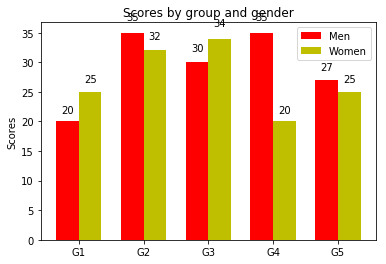

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

N = 5
men_means = (20, 35, 30, 35, 27)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color='r')

women_means = (25, 32, 34, 20, 25)
rects2 = ax.bar(ind + width, women_means, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()